<a href="https://colab.research.google.com/github/viti1igo/WeatherForecasting/blob/main/WeatherForecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
"""
- Đối vơi hướng gió, thì thay thế NULL val thành -> UNKNOWN (không ảnh hưởng đến dataset)
- Xử lý các value số (trừ 2 cột cuối là dự đoán mưa) bằng MEAN rồi tạo DF riêng với các cột đó, tạo 1 model KNN để dự đoán Cloud
- Có hết các value rồi thì dùng RandomForest để dự đoán.
"""

#Importing Libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd /content/drive/MyDrive/IntroToData/AT3

/content/drive/MyDrive/IntroToData/AT3


In [ ]:
#LIBRARY IMPORTING
import csv
import numpy as np
import pandas as pd
#Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
#Data Cleaning
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
#Feature Engineering
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif, f_classif
#Oversampling - Undersampling
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import ClusterCentroids
from imblearn.pipeline import Pipeline
#Deploying model
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.layers import Dropout
from keras.regularizers import l2
from tensorflow.keras.layers import BatchNormalization
#Evaluating model
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_fscore_support
from yellowbrick.classifier import ClassificationReport
import plotly.express as px
import plotly.graph_objects as go
from sklearn.metrics import ConfusionMatrixDisplay

#Load Dataset

In [ ]:
train_data = pd.read_csv('Assignment3-WeatherData.csv')
train_data.head()

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,WSW,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,0
1,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,E,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,0
2,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,NW,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,0
3,Albury,9.7,31.9,0.0,NaN,NaN,NNW,80.0,SE,NW,...,42.0,9.0,1008.9,1003.6,NaN,NaN,18.3,30.2,No,1
4,Albury,13.1,30.1,1.4,NaN,NaN,W,28.0,S,SSE,...,58.0,27.0,1007.0,1005.7,NaN,NaN,20.1,28.2,Yes,0


In [ ]:
test_data = pd.read_csv('Assignment3-UnknownData.csv')
test_data = test_data.drop(columns=['row ID'])
test_data.head()

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday
0,Albury,14.6,29.7,0.2,NaN,NaN,WNW,56.0,W,W,...,24.0,55.0,23.0,1009.2,1005.4,NaN,NaN,20.6,28.9,No
1,Albury,19.7,27.2,0.0,NaN,NaN,WNW,46.0,NW,WSW,...,30.0,49.0,22.0,1004.8,1004.2,NaN,NaN,21.6,26.1,No
2,Albury,21.7,36.9,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,11.0,53.0,26.0,1008.8,1004.7,NaN,NaN,25.5,35.2,No
3,Albury,14.9,27.3,0.0,NaN,NaN,SSE,41.0,SSE,SE,...,13.0,50.0,30.0,1011.6,1008.5,NaN,1.0,17.4,25.8,No
4,Albury,13.2,31.9,0.0,NaN,NaN,NNW,35.0,S,ENE,...,9.0,53.0,25.0,1014.1,1011.6,NaN,NaN,18.0,29.8,No


#Explore Dataset

###Training set

In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51199 entries, 0 to 51198
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Location       51199 non-null  object 
 1   MinTemp        50959 non-null  float64
 2   MaxTemp        51085 non-null  float64
 3   Rainfall       50667 non-null  float64
 4   Evaporation    29227 non-null  float64
 5   Sunshine       26720 non-null  float64
 6   WindGustDir    47878 non-null  object 
 7   WindGustSpeed  47901 non-null  float64
 8   WindDir9am     47564 non-null  object 
 9   WindDir3pm     49795 non-null  object 
 10  WindSpeed9am   50695 non-null  float64
 11  WindSpeed3pm   50199 non-null  float64
 12  Humidity9am    50531 non-null  float64
 13  Humidity3pm    49840 non-null  float64
 14  Pressure9am    46138 non-null  float64
 15  Pressure3pm    46136 non-null  float64
 16  Cloud9am       31795 non-null  float64
 17  Cloud3pm       30551 non-null  float64
 18  Temp9a

In [ ]:
print(train_data.isnull().sum())
"""
Consider to remove: Evaporation, Sunshine, Cloud3pm, Cloud9am

Evaporation: 21,972 missing values (43% missing).
Sunshine: 24,479 missing values (approximately 48% missing).
WindGustDir: 3,321 missing values (6.5% missing).
WindGustSpeed: 3,298 missing values (6.4% missing).
WindDir9am: 3,635 missing values (7% missing).
WindDir3pm: 1,404 missing values (approximately 2.7% missing).
Humidity9am: 668 missing values (1.3% missing).
Humidity3pm: 1,359 missing values (approximately 2.7% missing).
Pressure9am: 5,061 missing values (approximately 10% missing).
Pressure3pm: 5,063 missing values (approximately 10% missing).
Cloud9am: 19,404 missing values (approximately 38% missing).
Cloud3pm: 20,648 missing values (approximately 40% missing)
"""

Location             0
MinTemp            240
MaxTemp            114
Rainfall           532
Evaporation      21972
Sunshine         24479
WindGustDir       3321
WindGustSpeed     3298
WindDir9am        3635
WindDir3pm        1404
WindSpeed9am       504
WindSpeed3pm      1000
Humidity9am        668
Humidity3pm       1359
Pressure9am       5061
Pressure3pm       5063
Cloud9am         19404
Cloud3pm         20648
Temp9am            348
Temp3pm           1038
RainToday          532
RainTomorrow         0
dtype: int64


'\nConsider to remove: Evaporation, Sunshine, Cloud3pm, Cloud9am\n\nEvaporation: 21,972 missing values (43% missing).\nSunshine: 24,479 missing values (approximately 48% missing).\nWindGustDir: 3,321 missing values (6.5% missing).\nWindGustSpeed: 3,298 missing values (6.4% missing).\nWindDir9am: 3,635 missing values (7% missing).\nWindDir3pm: 1,404 missing values (approximately 2.7% missing).\nHumidity9am: 668 missing values (1.3% missing).\nHumidity3pm: 1,359 missing values (approximately 2.7% missing).\nPressure9am: 5,061 missing values (approximately 10% missing).\nPressure3pm: 5,063 missing values (approximately 10% missing).\nCloud9am: 19,404 missing values (approximately 38% missing).\nCloud3pm: 20,648 missing values (approximately 40% missing)\n'

In [ ]:
train_data.describe(include='all')

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
count,51199,50959.000000,51085.000000,50667.000000,29227.000000,26720.000000,47878,47901.000000,47564,49795,...,50531.000000,49840.000000,46138.000000,46136.000000,31795.000000,30551.000000,50851.000000,50161.000000,50667,51199.000000
unique,49,NaN,NaN,NaN,NaN,NaN,16,NaN,16,16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN
top,Canberra,NaN,NaN,NaN,NaN,NaN,W,NaN,N,SE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,NaN
freq,1274,NaN,NaN,NaN,NaN,NaN,3465,NaN,4107,3791,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39281,NaN
mean,NaN,12.191242,23.227157,2.322616,5.454296,7.627231,NaN,39.991775,NaN,NaN,...,68.835824,51.493319,1017.653617,1015.250889,4.440950,4.506825,16.990897,21.691701,NaN,0.224047
std,NaN,6.417429,7.148487,8.135593,4.083712,3.779703,NaN,13.532957,NaN,NaN,...,19.024289,20.832065,7.128786,7.065222,2.882738,2.717021,6.508125,6.966723,NaN,0.416957
min,NaN,-8.500000,-4.100000,0.000000,0.000000,0.000000,NaN,6.000000,NaN,NaN,...,1.000000,0.000000,980.500000,979.000000,0.000000,0.000000,-6.200000,-4.400000,NaN,0.000000
25%,NaN,7.600000,17.900000,0.000000,2.600000,4.900000,NaN,31.000000,NaN,NaN,...,57.000000,37.000000,1012.900000,1010.400000,1.000000,2.000000,12.250000,16.600000,NaN,0.000000
50%,NaN,12.000000,22.600000,0.000000,4.800000,8.500000,NaN,39.000000,NaN,NaN,...,70.000000,52.000000,1017.600000,1015.200000,5.000000,5.000000,16.700000,21.100000,NaN,0.000000
75%,NaN,16.900000,28.300000,0.800000,7.400000,10.600000,NaN,48.000000,NaN,NaN,...,83.000000,66.000000,1022.400000,1020.000000,7.000000,7.000000,21.600000,26.500000,NaN,0.000000


In [ ]:
train_data.shape

(51199, 22)

In [ ]:
train_data.columns

Index(['Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'RainToday', 'RainTomorrow'],
      dtype='object')

###Test set

In [ ]:
test_data.describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
count,9924.000000,9944.000000,9882.000000,5756.000000,5296.000000,9272.000000,9880.000000,9776.000000,9868.000000,9718.000000,9014.000000,9003.000000,6251.000000,6025.000000,9912.000000,9769.000000
mean,12.202842,23.247597,2.439557,5.434329,7.623867,39.946613,14.103947,18.738134,68.950142,51.596110,1017.673286,1015.269866,4.443449,4.485477,17.001816,21.684359
std,6.376473,7.074712,9.276759,4.245103,3.786193,13.759458,8.987176,8.947643,18.895856,20.673903,7.066974,7.014114,2.900338,2.716245,6.471643,6.868826
min,-7.200000,-2.100000,0.000000,0.000000,0.000000,7.000000,0.000000,0.000000,1.000000,1.000000,989.600000,981.900000,0.000000,0.000000,-5.300000,-3.500000
25%,7.700000,18.000000,0.000000,2.600000,4.900000,30.000000,7.000000,13.000000,57.000000,37.000000,1013.000000,1010.500000,1.000000,2.000000,12.200000,16.600000
50%,12.000000,22.600000,0.000000,4.800000,8.400000,39.000000,13.000000,19.000000,70.000000,52.000000,1017.800000,1015.300000,5.000000,5.000000,16.700000,21.100000
75%,16.800000,28.200000,0.600000,7.200000,10.700000,48.000000,19.000000,24.000000,83.000000,66.000000,1022.400000,1020.000000,7.000000,7.000000,21.600000,26.300000
max,31.900000,48.100000,278.400000,82.400000,14.200000,120.000000,74.000000,67.000000,100.000000,100.000000,1040.200000,1037.100000,8.000000,8.000000,36.200000,46.100000


In [ ]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9965 entries, 0 to 9964
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Location       9965 non-null   object 
 1   MinTemp        9924 non-null   float64
 2   MaxTemp        9944 non-null   float64
 3   Rainfall       9882 non-null   float64
 4   Evaporation    5756 non-null   float64
 5   Sunshine       5296 non-null   float64
 6   WindGustDir    9267 non-null   object 
 7   WindGustSpeed  9272 non-null   float64
 8   WindDir9am     9294 non-null   object 
 9   WindDir3pm     9700 non-null   object 
 10  WindSpeed9am   9880 non-null   float64
 11  WindSpeed3pm   9776 non-null   float64
 12  Humidity9am    9868 non-null   float64
 13  Humidity3pm    9718 non-null   float64
 14  Pressure9am    9014 non-null   float64
 15  Pressure3pm    9003 non-null   float64
 16  Cloud9am       6251 non-null   float64
 17  Cloud3pm       6025 non-null   float64
 18  Temp9am 

In [ ]:
test_data.describe(include='all')

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday
count,9965,9924.000000,9944.000000,9882.000000,5756.000000,5296.000000,9267,9272.000000,9294,9700,...,9776.000000,9868.000000,9718.000000,9014.000000,9003.000000,6251.000000,6025.000000,9912.000000,9769.000000,9882
unique,49,NaN,NaN,NaN,NaN,NaN,16,NaN,16,16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
top,Albany,NaN,NaN,NaN,NaN,NaN,W,NaN,N,SE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
freq,246,NaN,NaN,NaN,NaN,NaN,675,NaN,758,776,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7685
mean,NaN,12.202842,23.247597,2.439557,5.434329,7.623867,NaN,39.946613,NaN,NaN,...,18.738134,68.950142,51.596110,1017.673286,1015.269866,4.443449,4.485477,17.001816,21.684359,NaN
std,NaN,6.376473,7.074712,9.276759,4.245103,3.786193,NaN,13.759458,NaN,NaN,...,8.947643,18.895856,20.673903,7.066974,7.014114,2.900338,2.716245,6.471643,6.868826,NaN
min,NaN,-7.200000,-2.100000,0.000000,0.000000,0.000000,NaN,7.000000,NaN,NaN,...,0.000000,1.000000,1.000000,989.600000,981.900000,0.000000,0.000000,-5.300000,-3.500000,NaN
25%,NaN,7.700000,18.000000,0.000000,2.600000,4.900000,NaN,30.000000,NaN,NaN,...,13.000000,57.000000,37.000000,1013.000000,1010.500000,1.000000,2.000000,12.200000,16.600000,NaN
50%,NaN,12.000000,22.600000,0.000000,4.800000,8.400000,NaN,39.000000,NaN,NaN,...,19.000000,70.000000,52.000000,1017.800000,1015.300000,5.000000,5.000000,16.700000,21.100000,NaN
75%,NaN,16.800000,28.200000,0.600000,7.200000,10.700000,NaN,48.000000,NaN,NaN,...,24.000000,83.000000,66.000000,1022.400000,1020.000000,7.000000,7.000000,21.600000,26.300000,NaN


In [ ]:
test_data.shape

(9965, 21)

#Data Preprocessing

- Consider to remove: Evaporation, Sunshine, Cloud3pm, Cloud9am.
- Options to clean the data:
1. use dropna()
df.dropna()
2. use mean
df['ColumnName'].fillna(df['ColumnName'].mean(), inplace=True)


In [ ]:
def label_encode(df, categorical_cols):
    # Initialize LabelEncoder
    label_encoder = LabelEncoder()

    # Encode categorical columns, excluding the target column
    for col in categorical_cols:
        if col != 'RainTomorrow':  # Ensure RainTomorrow remains unchanged
            # Convert the column to string to avoid issues with mixed types
            df[col] = df[col].astype(str)  # Ensure all values are strings
            df[col] = label_encoder.fit_transform(df[col])

    return df

In [ ]:
categorical_cols = ['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday']

###OFFICIALLY TRAIN_DATA PREPROCESSING

In [ ]:
#Fill median into NaN in the 'MaxTemp'
train_data['MaxTemp']=train_data['MaxTemp'].fillna(train_data['MaxTemp'].median())

In [ ]:
#Fill mean into NaN in the 'MinTemp'
train_data['MinTemp']=train_data['MinTemp'].fillna(train_data['MinTemp'].mean())

In [ ]:
#Fill mean into NaN in the 'WindGustSpeed'
train_data['WindGustSpeed']=train_data['WindGustSpeed'].fillna(train_data['WindGustSpeed'].mean())

In [ ]:
#Fill mean into NaN in the 'Evaporation'
train_data['Evaporation']=train_data['Evaporation'].fillna(train_data['Evaporation'].mean())

In [ ]:
#Fill mean into NaN in the 'Sunshine'
train_data['Sunshine']=train_data['Sunshine'].fillna(train_data['Sunshine'].mean())

In [ ]:
#Fill mode into NaN in the 'WindGustDir'
train_data['WindGustDir']=train_data['WindGustDir'].fillna(train_data['WindGustDir'].mode())

In [ ]:
#Fill mode into NaN in the 'WindDir9am'
train_data['WindDir9am']=train_data['WindDir9am'].fillna(train_data['WindDir9am'].mode())

In [ ]:
#Fill mean into NaN in the 'Pressure9am'
train_data['Pressure9am']=train_data['Pressure9am'].fillna(train_data['Pressure9am'].mean())

In [ ]:
#Fill mean into NaN in the 'Pressure3pm'
train_data['Pressure3pm']=train_data['Pressure3pm'].fillna(train_data['Pressure3pm'].mean())

In [ ]:
#Fill mean into NaN in the 'Cloud9am'
train_data['Cloud9am']=train_data['Cloud9am'].fillna(train_data['Cloud9am'].mean())

In [ ]:
#Fill mean into NaN in the 'Cloud3pm'
train_data['Cloud3pm']=train_data['Cloud3pm'].fillna(train_data['Cloud3pm'].mean())

In [ ]:
#Fill mean into NaN in the 'Temp9am'
train_data['Temp9am']=train_data['Temp9am'].fillna(train_data['Temp9am'].mean())

In [ ]:
#Fill mean into NaN in the 'Temp3pm'
train_data['Temp3pm']=train_data['Temp3pm'].fillna(train_data['Temp3pm'].mean())

In [ ]:
train_data.dropna(inplace=True)

In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 43840 entries, 0 to 51198
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Location       43840 non-null  object 
 1   MinTemp        43840 non-null  float64
 2   MaxTemp        43840 non-null  float64
 3   Rainfall       43840 non-null  float64
 4   Evaporation    43840 non-null  float64
 5   Sunshine       43840 non-null  float64
 6   WindGustDir    43840 non-null  object 
 7   WindGustSpeed  43840 non-null  float64
 8   WindDir9am     43840 non-null  object 
 9   WindDir3pm     43840 non-null  object 
 10  WindSpeed9am   43840 non-null  float64
 11  WindSpeed3pm   43840 non-null  float64
 12  Humidity9am    43840 non-null  float64
 13  Humidity3pm    43840 non-null  float64
 14  Pressure9am    43840 non-null  float64
 15  Pressure3pm    43840 non-null  float64
 16  Cloud9am       43840 non-null  float64
 17  Cloud3pm       43840 non-null  float64
 18  Temp9am    

In [ ]:
train_data.isnull().sum()

,0
Location,0
MinTemp,0
MaxTemp,0
Rainfall,0
Evaporation,0
Sunshine,0
WindGustDir,0
WindGustSpeed,0
WindDir9am,0
WindDir3pm,0


In [ ]:
train_data = train_data.drop_duplicates()
train_data.duplicated().sum()

0

In [ ]:
label_encode(train_data, categorical_cols)

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,1,12.9,25.7,0.0,5.454296,7.627231,15,46.0,13,15,...,38.0,30.0,1007.6,1008.7,4.44095,2.000000,21.0,23.2,0,0
1,1,9.2,28.0,0.0,5.454296,7.627231,4,24.0,9,0,...,45.0,16.0,1017.6,1012.8,4.44095,4.506825,18.1,26.5,0,0
2,1,17.5,32.3,1.0,5.454296,7.627231,13,41.0,1,7,...,82.0,33.0,1010.8,1006.0,7.00000,8.000000,17.8,29.7,0,0
3,1,9.7,31.9,0.0,5.454296,7.627231,6,80.0,9,7,...,42.0,9.0,1008.9,1003.6,4.44095,4.506825,18.3,30.2,0,1
4,1,13.1,30.1,1.4,5.454296,7.627231,13,28.0,8,10,...,58.0,27.0,1007.0,1005.7,4.44095,4.506825,20.1,28.2,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51194,39,2.4,19.1,0.0,5.454296,7.627231,0,33.0,9,0,...,59.0,24.0,1030.0,1026.2,4.44095,4.506825,8.0,18.8,0,0
51195,39,5.1,19.7,0.0,5.454296,7.627231,0,46.0,2,0,...,56.0,29.0,1028.5,1025.8,4.44095,4.506825,8.5,19.2,0,0
51196,39,2.3,21.4,0.0,5.454296,7.627231,9,22.0,9,10,...,60.0,28.0,1026.9,1022.8,4.44095,4.506825,8.9,20.3,0,0
51197,39,5.2,24.3,0.0,5.454296,7.627231,0,24.0,9,0,...,53.0,24.0,1023.8,1020.0,4.44095,4.506825,12.3,23.3,0,0


In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 43840 entries, 0 to 51198
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Location       43840 non-null  int64  
 1   MinTemp        43840 non-null  float64
 2   MaxTemp        43840 non-null  float64
 3   Rainfall       43840 non-null  float64
 4   Evaporation    43840 non-null  float64
 5   Sunshine       43840 non-null  float64
 6   WindGustDir    43840 non-null  int64  
 7   WindGustSpeed  43840 non-null  float64
 8   WindDir9am     43840 non-null  int64  
 9   WindDir3pm     43840 non-null  int64  
 10  WindSpeed9am   43840 non-null  float64
 11  WindSpeed3pm   43840 non-null  float64
 12  Humidity9am    43840 non-null  float64
 13  Humidity3pm    43840 non-null  float64
 14  Pressure9am    43840 non-null  float64
 15  Pressure3pm    43840 non-null  float64
 16  Cloud9am       43840 non-null  float64
 17  Cloud3pm       43840 non-null  float64
 18  Temp9am    

In [ ]:
train_data.describe()

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
count,43840.000000,43840.000000,43840.000000,43840.000000,43840.000000,43840.000000,43840.000000,43840.000000,43840.000000,43840.000000,...,43840.000000,43840.000000,43840.000000,43840.000000,43840.000000,43840.000000,43840.000000,43840.000000,43840.000000,43840.000000
mean,22.835789,12.401736,23.441017,2.339261,5.524355,7.682197,7.732801,40.688777,7.272856,7.777600,...,67.687272,50.824019,1017.443909,1015.062263,4.434037,4.501410,17.221223,21.913009,0.224749,0.220849
std,13.655641,6.347666,7.161615,8.211218,3.164932,2.789696,4.652225,13.328386,4.560799,4.620297,...,19.021151,20.977523,6.799122,6.734567,2.272045,2.128144,6.469121,7.031032,0.417422,0.414823
min,0.000000,-8.500000,-3.200000,0.000000,0.000000,0.000000,0.000000,9.000000,0.000000,0.000000,...,2.000000,0.000000,980.500000,979.000000,0.000000,0.000000,-6.200000,-4.200000,0.000000,0.000000
25%,11.000000,7.800000,18.000000,0.000000,4.200000,7.627231,4.000000,31.000000,3.000000,4.000000,...,56.000000,36.000000,1013.200000,1010.700000,3.000000,4.000000,12.500000,16.700000,0.000000,0.000000
50%,23.000000,12.200000,22.900000,0.000000,5.454296,7.627231,8.000000,39.000000,7.000000,8.000000,...,69.000000,51.000000,1017.653617,1015.250889,4.440950,4.506825,16.900000,21.400000,0.000000,0.000000
75%,35.000000,17.000000,28.600000,0.800000,5.600000,9.100000,12.000000,48.000000,11.000000,12.000000,...,82.000000,65.000000,1021.700000,1019.300000,6.000000,6.000000,21.800000,26.800000,0.000000,0.000000
max,46.000000,33.900000,47.300000,268.600000,72.200000,14.500000,15.000000,130.000000,15.000000,15.000000,...,100.000000,100.000000,1040.300000,1037.900000,9.000000,8.000000,39.000000,46.700000,1.000000,1.000000


###OFFICIALLY TEST_DATA PREPROCESSING

In [ ]:
#Fill median into NaN in the 'MaxTemp'
test_data['MaxTemp']=test_data['MaxTemp'].fillna(test_data['MaxTemp'].median())

In [ ]:
#Fill mean into NaN in the 'MinTemp'
test_data['MinTemp']=test_data['MinTemp'].fillna(test_data['MinTemp'].mean())

In [ ]:
#Fill mean into NaN in the 'WindGustSpeed'
test_data['WindGustSpeed']=test_data['WindGustSpeed'].fillna(test_data['WindGustSpeed'].mean())

In [ ]:
#Fill mean into NaN in the 'Evaporation'
test_data['Evaporation']=test_data['Evaporation'].fillna(test_data['Evaporation'].mean())

In [ ]:
#Fill mean into NaN in the 'Sunshine'
test_data['Sunshine']=test_data['Sunshine'].fillna(test_data['Sunshine'].mean())

In [ ]:
#Fill mode into NaN in the 'WindGustDir'
test_data['WindGustDir'].fillna(test_data['WindGustDir'].mode()[0], inplace=True)

<ipython-input-283-f299571917ec>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test_data['WindGustDir'].fillna(test_data['WindGustDir'].mode()[0], inplace=True)


In [ ]:
#Fill mode into NaN in the 'WindDir9am' & 'WindDir3pm'
test_data['WindDir9am'].fillna(test_data['WindDir9am'].mode()[0], inplace=True)
test_data['WindDir3pm'].fillna(test_data['WindDir3pm'].mode()[0], inplace=True)

<ipython-input-284-a1889a3fc843>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test_data['WindDir9am'].fillna(test_data['WindDir9am'].mode()[0], inplace=True)
<ipython-input-284-a1889a3fc843>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].metho

In [ ]:
#Fill mean into NaN in the 'Pressure9am'
test_data['Pressure9am']=test_data['Pressure9am'].fillna(test_data['Pressure9am'].mean())

In [ ]:
#Fill mean into NaN in the 'Pressure3pm'
test_data['Pressure3pm']=test_data['Pressure3pm'].fillna(test_data['Pressure3pm'].mean())

In [ ]:
#Fill mean into NaN in the 'Cloud9am'
test_data['Cloud9am']=test_data['Cloud9am'].fillna(test_data['Cloud9am'].mean())

In [ ]:
#Fill mean into NaN in the 'Cloud3pm'
test_data['Cloud3pm']=test_data['Cloud3pm'].fillna(test_data['Cloud3pm'].mean())

In [ ]:
#Fill mean into NaN in the 'Temp9am'
test_data['Temp9am']=test_data['Temp9am'].fillna(test_data['Temp9am'].mean())

In [ ]:
#Fill mean into NaN in the 'Temp3pm'
test_data['Temp3pm']=test_data['Temp3pm'].fillna(test_data['Temp3pm'].mean())

In [ ]:
#Fill the rest NaN as mean into the dataset
numeric_cols = test_data.columns.difference(categorical_cols)
test_data[numeric_cols] = test_data[numeric_cols].fillna(test_data[numeric_cols].mean())

In [ ]:
#RainToday
test_data['RainToday'].fillna(test_data['RainToday'].mode()[0], inplace=True)

<ipython-input-292-f3b03c730ada>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test_data['RainToday'].fillna(test_data['RainToday'].mode()[0], inplace=True)


In [ ]:
test_data.shape

(9965, 21)

In [ ]:
test_data.isnull().sum()

,0
Location,0
MinTemp,0
MaxTemp,0
Rainfall,0
Evaporation,0
Sunshine,0
WindGustDir,0
WindGustSpeed,0
WindDir9am,0
WindDir3pm,0


In [ ]:
label_encode(test_data, categorical_cols)

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday
0,2,14.6,29.7,0.2,5.434329,7.623867,14,56.000000,13,13,...,24.0,55.0,23.0,1009.2,1005.4,4.443449,4.485477,20.6,28.9,0
1,2,19.7,27.2,0.0,5.434329,7.623867,14,46.000000,7,15,...,30.0,49.0,22.0,1004.8,1004.2,4.443449,4.485477,21.6,26.1,0
2,2,21.7,36.9,0.0,5.434329,7.623867,13,39.946613,3,9,...,11.0,53.0,26.0,1008.8,1004.7,4.443449,4.485477,25.5,35.2,0
3,2,14.9,27.3,0.0,5.434329,7.623867,10,41.000000,10,9,...,13.0,50.0,30.0,1011.6,1008.5,4.443449,1.000000,17.4,25.8,0
4,2,13.2,31.9,0.0,5.434329,7.623867,6,35.000000,8,1,...,9.0,53.0,25.0,1014.1,1011.6,4.443449,4.485477,18.0,29.8,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9960,41,25.6,40.6,0.2,5.434329,7.623867,1,56.000000,3,3,...,11.0,47.0,27.0,1007.3,1003.2,4.443449,1.000000,32.0,38.6,0
9961,41,15.9,38.2,0.0,5.434329,7.623867,10,37.000000,0,10,...,19.0,15.0,8.0,1012.5,1008.8,4.443449,4.485477,28.3,37.8,0
9962,41,17.5,39.7,0.0,5.434329,7.623867,11,48.000000,8,5,...,11.0,22.0,9.0,1009.5,1005.6,4.443449,4.485477,26.9,38.6,0
9963,41,23.1,39.9,0.0,5.434329,7.623867,1,37.000000,0,14,...,13.0,33.0,16.0,1012.3,1007.7,4.443449,4.485477,28.1,37.8,0


In [ ]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9965 entries, 0 to 9964
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Location       9965 non-null   int64  
 1   MinTemp        9965 non-null   float64
 2   MaxTemp        9965 non-null   float64
 3   Rainfall       9965 non-null   float64
 4   Evaporation    9965 non-null   float64
 5   Sunshine       9965 non-null   float64
 6   WindGustDir    9965 non-null   int64  
 7   WindGustSpeed  9965 non-null   float64
 8   WindDir9am     9965 non-null   int64  
 9   WindDir3pm     9965 non-null   int64  
 10  WindSpeed9am   9965 non-null   float64
 11  WindSpeed3pm   9965 non-null   float64
 12  Humidity9am    9965 non-null   float64
 13  Humidity3pm    9965 non-null   float64
 14  Pressure9am    9965 non-null   float64
 15  Pressure3pm    9965 non-null   float64
 16  Cloud9am       9965 non-null   float64
 17  Cloud3pm       9965 non-null   float64
 18  Temp9am 

In [ ]:
test_data.describe()

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday
count,9965.000000,9965.000000,9965.000000,9965.000000,9965.000000,9965.000000,9965.000000,9965.000000,9965.000000,9965.000000,...,9965.000000,9965.000000,9965.00000,9965.000000,9965.000000,9965.000000,9965.000000,9965.000000,9965.000000,9965.000000
mean,23.741094,12.202842,23.246232,2.439557,5.434329,7.623867,8.098043,39.946613,7.102760,7.783442,...,18.738134,68.950142,51.59611,1017.673286,1015.269866,4.443449,4.485477,17.001816,21.684359,0.220472
std,14.241868,6.363340,7.067315,9.238041,3.226220,2.760062,4.707195,13.272348,4.501848,4.484850,...,8.862376,18.803655,20.41605,6.721270,6.666923,2.297057,2.112003,6.454408,6.800933,0.414586
min,0.000000,-7.200000,-2.100000,0.000000,0.000000,0.000000,0.000000,7.000000,0.000000,0.000000,...,0.000000,1.000000,1.00000,989.600000,981.900000,0.000000,0.000000,-5.300000,-3.500000,0.000000
25%,11.000000,7.700000,18.000000,0.000000,4.000000,7.623867,4.000000,31.000000,3.000000,4.000000,...,13.000000,57.000000,37.00000,1013.600000,1010.900000,3.000000,4.000000,12.300000,16.700000,0.000000
50%,24.000000,12.000000,22.600000,0.000000,5.434329,7.623867,9.000000,39.000000,7.000000,8.000000,...,18.738134,70.000000,52.00000,1017.673286,1015.269866,4.443449,4.485477,16.700000,21.300000,0.000000
75%,36.000000,16.800000,28.100000,0.800000,5.434329,8.800000,13.000000,46.000000,11.000000,12.000000,...,24.000000,83.000000,65.00000,1021.900000,1019.400000,6.000000,6.000000,21.600000,26.200000,0.000000
max,48.000000,31.900000,48.100000,278.400000,82.400000,14.200000,15.000000,120.000000,15.000000,15.000000,...,67.000000,100.000000,100.00000,1040.200000,1037.100000,8.000000,8.000000,36.200000,46.100000,1.000000


#Handle outliers with Isolation Matrix

###Train data v2

In [ ]:
isolation_forest = IsolationForest(n_estimators=200, max_samples='auto', contamination=float(0.1), max_features=1.0)
isolation_forest.fit(train_data)

IsolationForest(contamination=0.1, n_estimators=200)

In [ ]:
predictions = isolation_forest.predict(train_data)
train_data_v2 = train_data[predictions == 1]
train_data_v2 = train_data_v2.reset_index(drop=True)
train_data_v2.shape

(39456, 22)

In [ ]:
train_data_v2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39456 entries, 0 to 39455
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Location       39456 non-null  int64  
 1   MinTemp        39456 non-null  float64
 2   MaxTemp        39456 non-null  float64
 3   Rainfall       39456 non-null  float64
 4   Evaporation    39456 non-null  float64
 5   Sunshine       39456 non-null  float64
 6   WindGustDir    39456 non-null  int64  
 7   WindGustSpeed  39456 non-null  float64
 8   WindDir9am     39456 non-null  int64  
 9   WindDir3pm     39456 non-null  int64  
 10  WindSpeed9am   39456 non-null  float64
 11  WindSpeed3pm   39456 non-null  float64
 12  Humidity9am    39456 non-null  float64
 13  Humidity3pm    39456 non-null  float64
 14  Pressure9am    39456 non-null  float64
 15  Pressure3pm    39456 non-null  float64
 16  Cloud9am       39456 non-null  float64
 17  Cloud3pm       39456 non-null  float64
 18  Temp9a

#Feature Engineering

Counts of RainTomorrow attribute:
RainTomorrow
0    34158
1     9682
Name: count, dtype: int64


<ipython-input-301-c59dd95746f4>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=train_data, x='RainTomorrow', palette='Set2')


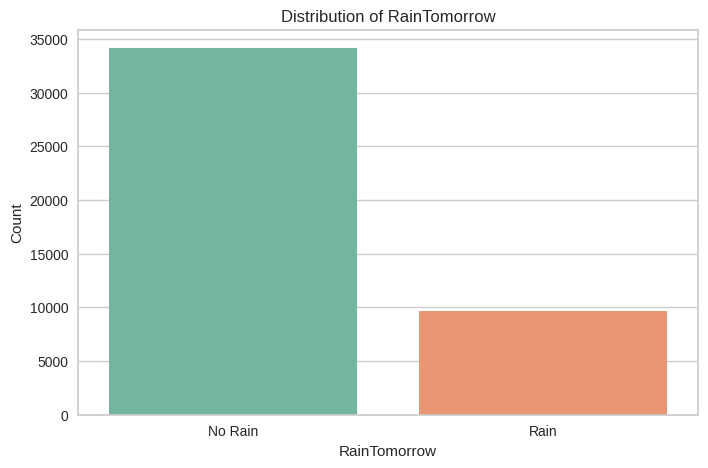

In [ ]:
# Check the distribution of the RainTomorrow attribute
rain_tomorrow_counts = train_data['RainTomorrow'].value_counts()

# Print the counts
print("Counts of RainTomorrow attribute:")
print(rain_tomorrow_counts)

# Plotting the distribution
plt.figure(figsize=(8, 5))
sns.countplot(data=train_data, x='RainTomorrow', palette='Set2')
plt.title('Distribution of RainTomorrow')
plt.xlabel('RainTomorrow')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['No Rain', 'Rain'])  # Adjust labels based on your dataset
plt.show()

Counts of RainTomorrow attribute:
RainTomorrow
0    32500
1     6956
Name: count, dtype: int64


<ipython-input-302-fe4a765883dd>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=train_data_v2, x='RainTomorrow', palette='Set2')


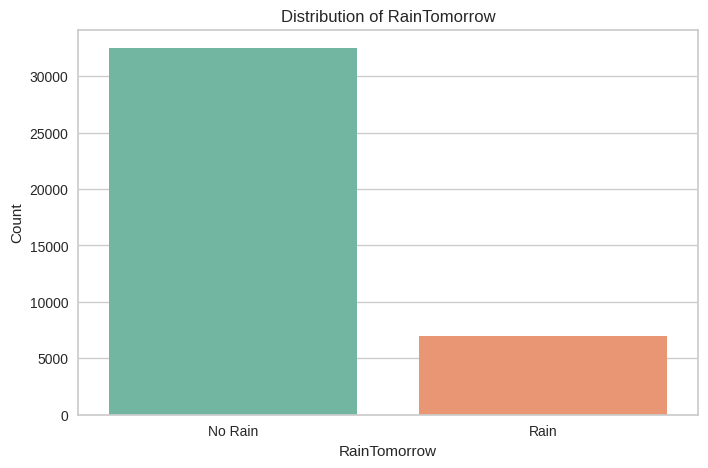

In [ ]:
# Check the distribution of the RainTomorrow attribute
rain_tomorrow_counts = train_data_v2['RainTomorrow'].value_counts()

# Print the counts
print("Counts of RainTomorrow attribute:")
print(rain_tomorrow_counts)

# Plotting the distribution
plt.figure(figsize=(8, 5))
sns.countplot(data=train_data_v2, x='RainTomorrow', palette='Set2')
plt.title('Distribution of RainTomorrow')
plt.xlabel('RainTomorrow')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['No Rain', 'Rain'])  # Adjust labels based on your dataset
plt.show()

In [ ]:
feature_names = ['Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'RainToday']

In [ ]:
k = 12
score_func = mutual_info_classif  #mutual_info_classif/f_classif

X = train_data_v2.drop(['RainTomorrow'], axis=1)
y = train_data_v2['RainTomorrow']

# Create the selector
selector = SelectKBest(score_func=score_func, k=k)

# Fit the selector to the data
selector.fit(X, y)

# Get selected feature indices
selected_indices = selector.get_support(indices=True)

# Get the scores of all features
scores = selector.scores_

# Create a DataFrame to hold feature names, scores, and ranking
feature_ranking = pd.DataFrame({
    'Feature': feature_names,
    'Score': scores
})

# Add a rank column based on scores (1 is the best)
feature_ranking['Rank'] = feature_ranking['Score'].rank(ascending=False)

# Sort by rank
feature_ranking = feature_ranking.sort_values(by='Rank')

# Get the top k features and their scores
top_features = feature_ranking.head(k)

# Display the results
print("Scores for each feature:", scores)
print("Selected feature indices:", selected_indices)

# Optional: Display the selected features and their scores
selected_scores = scores[selected_indices]
print("Selected features' scores:", selected_scores)

# Map selected feature indices to their names
selected_feature_names = [feature_names[i] for i in selected_indices]

# Display the selected feature names
print("Selected feature names:")
for name in selected_feature_names:
    print(name)

# Display all features with their scores and ranks
print("\nAll features with their scores and ranks:")
print(feature_ranking)

# Display only the top k features
print(f"\nTop {k} features based on their scores:")
print(top_features)


Scores for each feature: [0.01471523 0.00343536 0.01157084 0.03153857 0.00712636 0.03956513
 0.00775157 0.01619244 0.0103142  0.00550569 0.00387574 0.0025721
 0.02928867 0.09602307 0.01510467 0.01215422 0.02462764 0.03887591
 0.00243169 0.01670649 0.02670479]
Selected feature indices: [ 0  3  5  7 12 13 14 15 16 17 19 20]
Selected features' scores: [0.01471523 0.03153857 0.03956513 0.01619244 0.02928867 0.09602307
 0.01510467 0.01215422 0.02462764 0.03887591 0.01670649 0.02670479]
Selected feature names:
Location
Rainfall
Sunshine
WindGustSpeed
Humidity9am
Humidity3pm
Pressure9am
Pressure3pm
Cloud9am
Cloud3pm
Temp3pm
RainToday

All features with their scores and ranks:
          Feature     Score  Rank
13    Humidity3pm  0.096023   1.0
5        Sunshine  0.039565   2.0
17       Cloud3pm  0.038876   3.0
3        Rainfall  0.031539   4.0
12    Humidity9am  0.029289   5.0
20      RainToday  0.026705   6.0
16       Cloud9am  0.024628   7.0
19        Temp3pm  0.016706   8.0
7   WindGustSpee

In [ ]:
"""
Chi2:
Top 12 features based on their scores:
          Feature        Score  Rank
20      RainToday  1253.004536   1.0
13      Humidity2   533.987654   2.0
17         Cloud2   341.248055   3.0
16         Cloud1   241.391689   4.0
3        Rainfall   209.657078   5.0
5        Sunshine   168.450401   6.0
12      Humidity1   106.334499   7.0
7   WindGustSpeed    63.371326   8.0
19          Temp2    49.205522   9.0
14      Pressure1    39.075476  10.0
2         MaxTemp    30.559905  11.0
15      Pressure2    28.468827  12.0

mutual_info_classif:
          Feature     Score  Rank
13    Humidity3pm  0.089975   1.0
5        Sunshine  0.039392   2.0
17       Cloud3pm  0.034699   3.0
12    Humidity9am  0.029623   4.0
3        Rainfall  0.027364   5.0
20      RainToday  0.024048   6.0
16       Cloud9am  0.021887   7.0
7   WindGustSpeed  0.020023   8.0
19        Temp3pm  0.017159   9.0
14    Pressure9am  0.015657  10.0
0        Location  0.012741  11.0
2         MaxTemp  0.012714  12.0

f_classif
13    Humidity3pm  7668.285849   1.0
5        Sunshine  2859.850295   2.0
17       Cloud3pm  2513.791177   3.0
12    Humidity9am  2092.792509   4.0
20      RainToday  1898.334259   5.0
16       Cloud9am  1491.760816   6.0
7   WindGustSpeed  1374.373117   7.0
19        Temp3pm  1355.565200   8.0
14    Pressure9am  1272.737633   9.0
3        Rainfall  1109.939280  10.0
15    Pressure3pm  1099.321393  11.0
2         MaxTemp   911.050554  12.0
-----
FINAL RESULT
-----
Humidity3pm
Sunshine
Cloud3pm
Humidity9am
RainToday
Cloud9am
WindGustSpeed
Temp3pm
Pressure9am
Rainfall
"""
[3, 5, 7, 12, 13, 14, 15, 16, 17, 19, 20]

[3, 5, 7, 12, 13, 14, 15, 16, 17, 19, 20]

In [ ]:
engineering_features = [
    "Humidity3pm",
    "Sunshine",
    "Cloud3pm",
    "Humidity9am",
    "RainToday",
    "Cloud9am",
    "WindGustSpeed",
    "Temp3pm",
    "Pressure9am",
    "Rainfall"
]

#Define X, y

In [ ]:
# Select X based on the specified engineering features
X = train_data_v2[engineering_features]  # Features (engineering features only)
y = train_data_v2['RainTomorrow']  # Target labels (RainTomorrow)

# Normalize the features (X), leaving the target (y) as is
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)  # Apply scaling only to features

# Convert scaled features back to DataFrame
X_scaled_df = pd.DataFrame(X_scaled, columns=engineering_features)

# No need to scale y, keeping the original binary values (0, 1)
y_df = pd.DataFrame(y, columns=['RainTomorrow'])

# For test data (Kaggle), apply the same scaling to the selected features
X_kaggle = scaler_X.transform(test_data[engineering_features])
X_kaggle_df = pd.DataFrame(X_kaggle, columns=engineering_features)

In [ ]:
X_kaggle_df.shape


(9965, 10)

In [ ]:
X_scaled_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39456 entries, 0 to 39455
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Humidity3pm    39456 non-null  float64
 1   Sunshine       39456 non-null  float64
 2   Cloud3pm       39456 non-null  float64
 3   Humidity9am    39456 non-null  float64
 4   RainToday      39456 non-null  float64
 5   Cloud9am       39456 non-null  float64
 6   WindGustSpeed  39456 non-null  float64
 7   Temp3pm        39456 non-null  float64
 8   Pressure9am    39456 non-null  float64
 9   Rainfall       39456 non-null  float64
dtypes: float64(10)
memory usage: 3.0 MB


#Sampling

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled_df, y, test_size=0.1, random_state=42)
X_train_selected = X_train[engineering_features]

In [ ]:
y_test.info()

<class 'pandas.core.series.Series'>
Index: 3946 entries, 5989 to 31654
Series name: RainTomorrow
Non-Null Count  Dtype
--------------  -----
3946 non-null   int64
dtypes: int64(1)
memory usage: 61.7 KB


In [ ]:
oversample = SMOTE(sampling_strategy='auto',
              k_neighbors=5,
              n_jobs=-1,
              random_state=42)
undersample = RandomUnderSampler(
    sampling_strategy='auto',
    random_state=42
)
pipeline = Pipeline(steps=[('o', oversample), ('u', undersample)])

In [ ]:
X_resampled, y_resampled = pipeline.fit_resample(X_train_selected, y_train)

/usr/local/lib/python3.10/dist-packages/imblearn/over_sampling/_smote/base.py:370: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


In [ ]:
print(X_resampled.shape)
print(y_resampled.shape)

(58498, 10)
(58498,)


In [ ]:
# Check the distribution of the RainTomorrow attribute
rain_tomorrow_counts = np.unique(y_resampled,return_counts=True)

# Print the counts
print("Counts of RainTomorrow attribute:")
print(rain_tomorrow_counts)




Counts of RainTomorrow attribute:
(array([0, 1]), array([29249, 29249]))


In [ ]:
y_resampled.value_counts()

,count
RainTomorrow,
0,29249
1,29249


#Deploy Model

In [ ]:
train_data_v2_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46079 entries, 0 to 46078
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Location       46079 non-null  int64  
 1   MinTemp        46079 non-null  float64
 2   MaxTemp        46079 non-null  float64
 3   Rainfall       46079 non-null  float64
 4   Evaporation    46079 non-null  float64
 5   Sunshine       46079 non-null  float64
 6   WindGustDir    46079 non-null  int64  
 7   WindGustSpeed  46079 non-null  float64
 8   WindDir9am     46079 non-null  int64  
 9   WindDir3pm     46079 non-null  int64  
 10  WindSpeed9am   46079 non-null  float64
 11  WindSpeed3pm   46079 non-null  float64
 12  Humidity9am    46079 non-null  float64
 13  Humidity3pm    46079 non-null  float64
 14  Pressure9am    46079 non-null  float64
 15  Pressure3pm    46079 non-null  float64
 16  Cloud9am       46079 non-null  float64
 17  Cloud3pm       46079 non-null  float64
 18  Temp9a

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled_df, y_scaled_df, test_size=0.2, random_state=42)
X_train_selected = X_train[engineering_features]

In [ ]:
"""
# Load the Kaggle submission file
y_test_data = pd.read_csv('Assignment3-Kaggle-Submission-Sample.csv')

# Assuming the target variable column is named 'RainTomorrow' or something similar
# Replace 'RainTomorrow' with the actual name of the column in your file
y_true = y_test_data['Predict-RainTomorrow']

# Display the first few rows to verify
print(y_true.head())
y_true.shape
"""

"\n# Load the Kaggle submission file\ny_test_data = pd.read_csv('Assignment3-Kaggle-Submission-Sample.csv')\n\n# Assuming the target variable column is named 'RainTomorrow' or something similar\n# Replace 'RainTomorrow' with the actual name of the column in your file\ny_true = y_test_data['Predict-RainTomorrow']\n\n# Display the first few rows to verify\nprint(y_true.head())\ny_true.shape\n"

###DecisionTree

In [ ]:
params_grid = {
    'criterion': ['gini'],
    'max_depth': [10,11,12],
    'min_samples_split': [12,13,14],
    'min_samples_leaf': [21,23,25],
    'max_features': ['log2']
}

In [ ]:
model = DecisionTreeClassifier()
dt_model = GridSearchCV(estimator=model, param_grid=params_grid, cv=5)
dt_model.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini'], 'max_depth': [10, 11, 12],
                         'max_features': ['log2'],
                         'min_samples_leaf': [21, 22, 23],
                         'min_samples_split': [12, 13, 14]})

In [ ]:
#Print best hyperparameters and best score
print("Best hyperparameters:", dt_model.best_params_)
print("Best score:", dt_model.best_score_)

Best hyperparameters: {'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 23, 'min_samples_split': 13}
Best score: 0.8464313818533535


In [ ]:
y_preds = dt_model.predict(X_test)

In [ ]:
f1 = f1_score(y_test, y_preds)
precision = precision_score(y_test, y_preds)
recall = recall_score(y_test, y_preds)
accuracy = accuracy_score(y_test, y_preds)
auc = roc_auc_score(y_test, y_preds)

print("F1 score: ", f1)
print("Precision score: ", precision)
print("Recall score: ", recall)
print("Accuracy: ", accuracy)
print("AUC: ", auc)

F1 score:  0.3830678960603521
Precision score:  0.5935064935064935
Recall score:  0.28279702970297027
Accuracy:  0.8402777777777778
AUC:  0.6208064095883272


In [ ]:
y_kaggle_preds = dt_model.predict(X_kaggle)

###RandomForest

In [ ]:
rf = RandomForestClassifier()

# Define the parameter grid for tuning
param_grid = {
    'n_estimators': [150,200,250],         # Number of trees in the forest
    'max_features': ['auto', 'sqrt', 'log2'],   # Number of features to consider at every split
    'max_depth': [None, 10, 15, 20],             # Maximum depth of the tree
    'min_samples_split': [11,13,15],             # Minimum number of samples required to split an internal node
    'min_samples_leaf': [21,23,25],               # Minimum number of samples required to be at a leaf node
    'bootstrap': [False]                   # Whether bootstrap samples are used when building trees
}

In [ ]:
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

In [ ]:
grid_search.fit(X_train_selected, y_train)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


KeyboardInterrupt: 

In [ ]:
print(f"Best Parameters: {grid_search.best_params_}")

Best Parameters: {'bootstrap': False, 'max_depth': 15, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 20}


In [ ]:
#Let the GridSearchCV predict
grid_search.predict(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


array([0., 0., 0., ..., 0., 0., 0.])

In [ ]:
rf_model = RandomForestClassifier(bootstrap=False, max_depth=9,
                                  max_features='log2',
                                  min_samples_split=7,
                                  n_estimators=700,
                                  class_weight='balanced',
                                  random_state=1)
rf_model.fit(X_resampled, y_resampled)

RandomForestClassifier(bootstrap=False, class_weight='balanced', max_depth=9,
                       max_features='log2', min_samples_split=7,
                       n_estimators=700, random_state=1)

In [ ]:
# Make predictions on training and testing sets
y_train_pred_prob = rf_model.predict(X_train_selected)
y_test_pred_prob = rf_model.predict(X_test[engineering_features])

# Convert probabilities to binary predictions using a threshold of 0.5
y_train_pred = (y_train_pred_prob > 0.5).astype(int)
y_test_pred = (y_test_pred_prob > 0.5).astype(int)

Training Score
F1 score:  0.6000645369474024
Precision score:  0.5034654537578515
Recall score:  0.7425331416706596
Accuracy:  0.8254857786539003
AUC:  0.7928878228439454
-------------------------------
Testing Score
F1 score:  0.5516840882694541
Precision score:  0.4625121713729309
Recall score:  0.6834532374100719
Accuracy:  0.8043588443993918
AUC:  0.7568296639218923


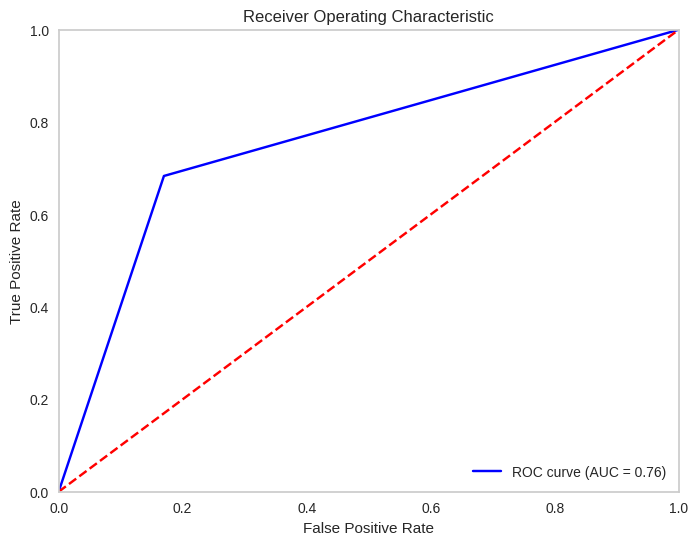

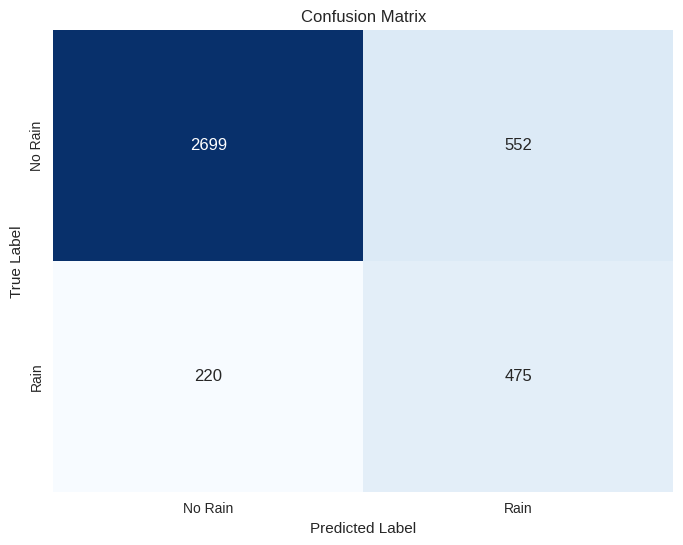

              precision    recall  f1-score   support

           0       0.92      0.83      0.87      3251
           1       0.46      0.68      0.55       695

    accuracy                           0.80      3946
   macro avg       0.69      0.76      0.71      3946
weighted avg       0.84      0.80      0.82      3946



In [ ]:
f1 = f1_score(y_train, y_train_pred)
precision = precision_score(y_train, y_train_pred)
recall = recall_score(y_train, y_train_pred)
accuracy = accuracy_score(y_train, y_train_pred)
auc = roc_auc_score(y_train, y_train_pred_prob)
cm = confusion_matrix(y_train, y_train_pred)
fpr, tpr, thresholds = roc_curve(y_train, y_train_pred)
print("Training Score")
print("F1 score: ", f1)
print("Precision score: ", precision)
print("Recall score: ", recall)
print("Accuracy: ", accuracy)
print("AUC: ", auc)
print("-------------------------------")
f1 = f1_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
accuracy = accuracy_score(y_test, y_test_pred)
auc = roc_auc_score(y_test, y_test_pred_prob)
cm = confusion_matrix(y_test, y_test_pred)
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred)
print("Testing Score")
print("F1 score: ", f1)
print("Precision score: ", precision)
print("Recall score: ", recall)
print("Accuracy: ", accuracy)
print("AUC: ", auc)
# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label='ROC curve (AUC = {:.2f})'.format(auc))
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.grid()
plt.show()
# Plot confusion matrix for better visualization
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['No Rain', 'Rain'], yticklabels=['No Rain', 'Rain'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Optionally print a classification report
print(classification_report(y_test, y_test_pred))

In [ ]:
"""
PREVIOUS RESULTS

rf_model = RandomForestClassifier(bootstrap=False, max_depth=9,
                                  max_features='log2',
                                  min_samples_split=8,
                                  n_estimators=700,
                                  class_weight='balanced',
                                  random_state=1)
rf_model.fit(X_resampled, y_resampled)

Training Score
F1 score:  0.660139104598555
Precision score:  0.57182966775854
Recall score:  0.780705957514774
Accuracy:  0.8582652773866516
AUC:  0.8277867371764782
-------------------------------
Testing Score
F1 score:  0.5591267434808975
Precision score:  0.4832285115303983
Recall score:  0.6633093525179856
Accuracy:  0.8157627977698936
AUC:  0.7558318525124532
"""

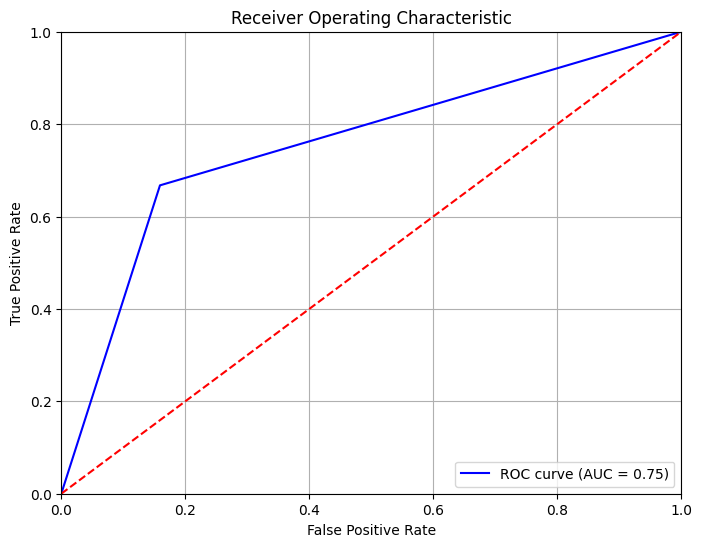

In [ ]:
# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label='ROC curve (AUC = {:.2f})'.format(auc))
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.grid()
plt.show()

In [ ]:
y_kaggle_preds = rf_model.predict(X_kaggle_df[engineering_features])

In [ ]:
X_kaggle

array([[0.04166667, 0.60471204, 0.68507157, ..., 0.61327231, 0.68200837,
        0.        ],
       [0.04166667, 0.7382199 , 0.63394683, ..., 0.63615561, 0.62343096,
        0.        ],
       [0.04166667, 0.79057592, 0.83231084, ..., 0.72540046, 0.81380753,
        0.        ],
       ...,
       [0.85416667, 0.68062827, 0.88957055, ..., 0.75743707, 0.88493724,
        0.        ],
       [0.85416667, 0.82722513, 0.89366053, ..., 0.78489703, 0.86820084,
        0.        ],
       [0.85416667, 0.52356021, 0.66257669, ..., 0.58581236, 0.65690377,
        0.        ]])

###K Nearest Neighbour (KNN)

In [ ]:
params_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

In [ ]:
knn_model = KNeighborsClassifier(
        n_neighbors=3,
        weights="uniform",
        algorithm="auto"
    )

In [ ]:
knn_model.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


KNeighborsClassifier(n_neighbors=3)

In [ ]:
f1 = f1_score(y_test, y_preds)
precision = precision_score(y_test, y_preds)
recall = recall_score(y_test, y_preds)
accuracy = accuracy_score(y_test, y_preds)

print("F1 score: ", f1)
print("Precision score: ", precision)
print("Recall score: ", recall)
print("Accuracy: ", accuracy)

F1 score:  0.4194690265486726
Precision score:  0.7360248447204969
Recall score:  0.2933168316831683
Accuracy:  0.8576388888888888


###Logistic Regression

In [ ]:
lr_model = LogisticRegression(
        penalty="l2",         # L2 regularization helps prevent overfitting by penalizing large coefficient
        dual=False,           # As using L2 penalty, using default as False (number of features is larger than the number of samples) to solve primal optimization problem.
        random_state=42,    # Sets a random seed for reproducibility, so that the results are the same every time we run the code. As using solver is lbfgs, I set the number to default as None.
        solver="lbfgs",       # 'lbfgs' is an efficient solver for small-to-medium datasets and supports multi-class classification as well as minimizing the cost function.
        max_iter=500          # Sets the maximum number of iterations for the solver to converge to the optimal solution.
    )

In [ ]:
lr_model.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(max_iter=500, random_state=42)

In [ ]:
f1 = f1_score(y_test, y_preds)
precision = precision_score(y_test, y_preds)
recall = recall_score(y_test, y_preds)
accuracy = accuracy_score(y_test, y_preds)
auc = roc_auc_score(y_test, y_preds)
fpr, tpr, thresholds = roc_curve(y_test, y_preds)

print("F1 score: ", f1)
print("Precision score: ", precision)
print("Recall score: ", recall)
print("Accuracy: ", accuracy)
print("AUC: ", auc)

F1 score:  0.4194690265486726
Precision score:  0.7360248447204969
Recall score:  0.2933168316831683
Accuracy:  0.8576388888888888
AUC:  0.6354742053152683


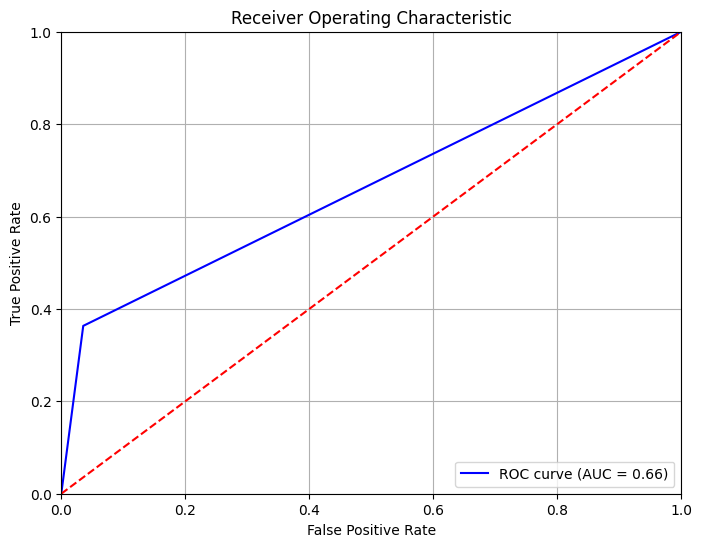

In [ ]:
# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label='ROC curve (AUC = {:.2f})'.format(auc))
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.grid()
plt.show()

###XGBoost

In [ ]:
#---FINDING THE BEST PARAMETERS---
# Define the XGBoost model
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Define the hyperparameter grid
param_grid = {
    'n_estimators': [100, 200],        # Number of trees
    'max_depth': [3, 4, 5],            # Maximum depth of the tree
    'learning_rate': [0.01, 0.1],      # Learning rate
    'scale_pos_weight': [len(y_train[y_train == 0]) / len(y_train[y_train == 1])]  # Class imbalance
}
# Create the GridSearchCV object
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='f1',
    cv=5,
    verbose=1,
    n_jobs=-1
)
# Fit the model
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


KeyboardInterrupt: 

In [ ]:
best_model = grid_search.best_estimator_
print(best_model)

In [ ]:
xgb_model = XGBClassifier(
    n_estimators=4200,          # Number of boosting rounds (trees)
    learning_rate=0.001,       # Learning rate (can tune)
    max_depth=7,               # Maximum depth of a tree (can tune)
    reg_alpha=0.1,              # L1 regularization term
    reg_lambda=0.1,             # L2 regularization term
    subsample=0.8,             # Subsample ratio of the training instance (can tune)
    colsample_bytree=0.8,      # Subsample ratio of columns when constructing each tree (can tune)
    random_state=42            # Random seed for reproducibility
)

In [ ]:
xgb_model.fit(X_resampled, y_resampled)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.001, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=4200, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [ ]:
#Make prediction
y_train_pred = xgb_model.predict(X_train_selected)
y_test_pred = xgb_model.predict(X_test[engineering_features])

In [ ]:
X_kaggle_df.shape

(9965, 10)

In [ ]:
f1 = f1_score(y_train, y_train_pred)
precision = precision_score(y_train, y_train_pred)
recall = recall_score(y_train, y_train_pred)
accuracy = accuracy_score(y_train, y_train_pred)
auc = roc_auc_score(y_train, y_train_pred)
fpr, tpr, thresholds = roc_curve(y_train, y_train_pred)
print("Training Score")
print("F1 score: ", f1)
print("Precision score: ", precision)
print("Recall score: ", recall)
print("Accuracy: ", accuracy)
print("AUC: ", auc)
print("-------------------------------")
f1 = f1_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
accuracy = accuracy_score(y_test, y_test_pred)
auc = roc_auc_score(y_test, y_test_pred)
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred)
print("Testing Score")
print("F1 score: ", f1)
print("Precision score: ", precision)
print("Recall score: ", recall)
print("Accuracy: ", accuracy)
print("AUC: ", auc)

Training Score
F1 score:  0.6063562865904656
Precision score:  0.5502846299810247
Recall score:  0.6751513270215738
Accuracy:  0.8409462123345537
AUC:  0.7764238418573655
-------------------------------
Testing Score
F1 score:  0.566579634464752
Precision score:  0.5087924970691676
Recall score:  0.6391752577319587
Accuracy:  0.831728332488596
AUC:  0.7554615192853243


In [ ]:
"""
PREVIOUS RESULTS

xgb_model = XGBClassifier(
    n_estimators=4200,          # Number of boosting rounds (trees)
    learning_rate=0.001,       # Learning rate (can tune)
    max_depth=7,               # Maximum depth of a tree (can tune)
    reg_alpha=0.1,              # L1 regularization term
    reg_lambda=0.1,             # L2 regularization term
    subsample=0.8,             # Subsample ratio of the training instance (can tune)
    colsample_bytree=0.8,      # Subsample ratio of columns when constructing each tree (can tune)
    random_state=42            # Random seed for reproducibility
)

Training Score
F1 score:  0.6079609888863687
Precision score:  0.5450386335908906
Recall score:  0.6873076923076923
Accuracy:  0.8332810879891973
AUC:  0.7772020033217354
-------------------------------
Testing Score
F1 score:  0.5763598326359832
Precision score:  0.5188323917137476
Recall score:  0.648235294117647
Accuracy:  0.82421875
AUC:  0.7561293554143318
"""

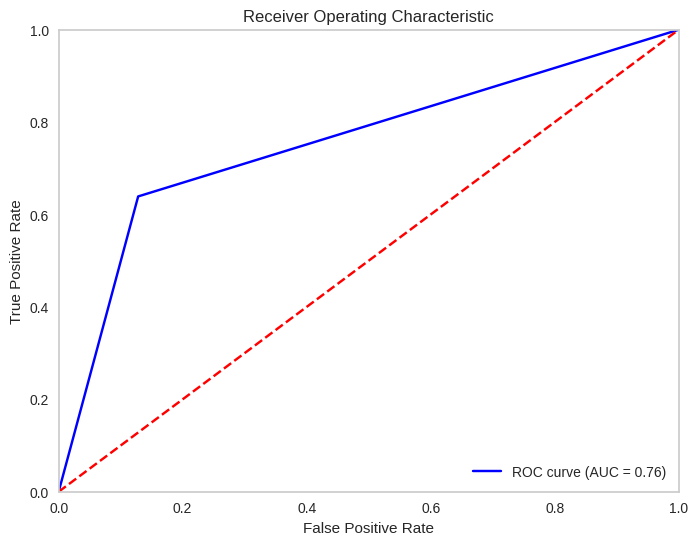

In [ ]:
# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label='ROC curve (AUC = {:.2f})'.format(auc))
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.grid()
plt.show()

In [ ]:
y_kaggle_preds = xgb_model.predict(X_kaggle_df[engineering_features])

In [ ]:
y_kaggle_preds.shape

(9965,)

###MLP - MultiLayer Perceptron - sklearn NN

In [ ]:
mlp_model = MLPClassifier(hidden_layer_sizes=(64, 32, 16, 8),
                          activation={'relu', 'tanh', 'sigmoid'},
                          solver='adam',
                          alpha=0.0005,
                          learning_rate='constant',
                          learning_rate_init=0.001,
                          max_iter=500,
                          random_state=42,
                          early_stopping=True,
                          validation_fraction=0.1,
                          batch_size=32)

In [ ]:
mlp_model.fit(X_resampled, y_resampled)

InvalidParameterError: The 'activation' parameter of MLPClassifier must be a str among {'tanh', 'identity', 'relu', 'logistic'}. Got {'tanh', 'relu', 'sigmoid'} instead.

In [ ]:
#Make prediction
y_train_pred = mlp_model.predict(X_train_selected)
y_test_pred = mlp_model.predict(X_test[engineering_features])

In [ ]:
test_score = mlp_model.score(X_resampled, y_resampled)
f1 = f1_score(y_train, y_train_pred)
precision = precision_score(y_train, y_train_pred)
recall = recall_score(y_train, y_train_pred)
accuracy = accuracy_score(y_train, y_train_pred)
auc = roc_auc_score(y_train, y_train_pred)
fpr, tpr, thresholds = roc_curve(y_train, y_train_pred)
print("Test score:", test_score)
print("Training Score")
print("F1 score: ", f1)
print("Precision score: ", precision)
print("Recall score: ", recall)
print("Accuracy: ", accuracy)
print("AUC: ", auc)
print("-------------------------------")
f1 = f1_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
accuracy = accuracy_score(y_test, y_test_pred)
auc = roc_auc_score(y_test, y_test_pred)
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred)
print("Testing Score")
print("F1 score: ", f1)
print("Precision score: ", precision)
print("Recall score: ", recall)
print("Accuracy: ", accuracy)
print("AUC: ", auc)

Test score: 0.806072072604724
Training Score
F1 score:  0.5807345145422418
Precision score:  0.4573147799924784
Recall score:  0.7953950811093669
Accuracy:  0.7883099033059247
AUC:  0.7910519615793088
-------------------------------
Testing Score
F1 score:  0.5604260548955347
Precision score:  0.4421460892049127
Recall score:  0.7651006711409396
Accuracy:  0.7671440972222222
AUC:  0.7663683215693928


In [ ]:
"""
mlp_model = MLPClassifier(hidden_layer_sizes=(64, 32, 16),
                          activation='relu',
                          solver='adam',
                          alpha=0.0005,
                          learning_rate='constant',
                          learning_rate_init=0.001,
                          max_iter=500,
                          random_state=42,
                          early_stopping=True,
                          validation_fraction=0.1,
                          batch_size=32)

Test score: 0.806072072604724
Training Score
F1 score:  0.5807345145422418
Precision score:  0.4573147799924784
Recall score:  0.7953950811093669
Accuracy:  0.7883099033059247
AUC:  0.7910519615793088
-------------------------------
Testing Score
F1 score:  0.5604260548955347
Precision score:  0.4421460892049127
Recall score:  0.7651006711409396
Accuracy:  0.7671440972222222
AUC:  0.7663683215693928
"""

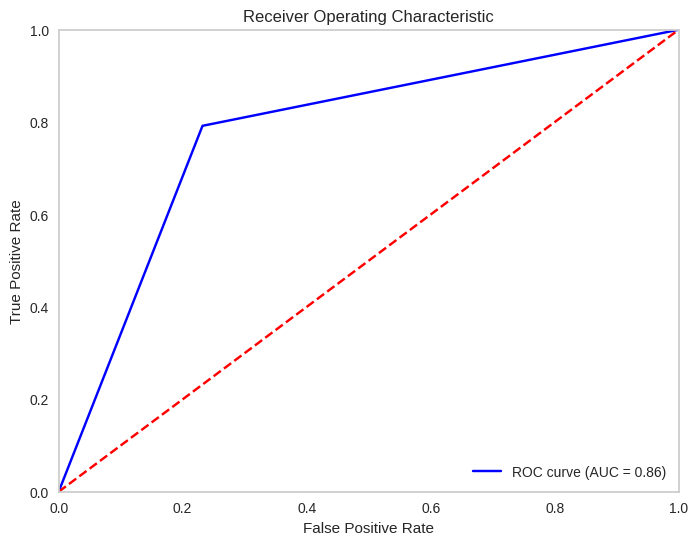

In [ ]:
# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label='ROC curve (AUC = {:.2f})'.format(auc))
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.grid()
plt.show()

In [ ]:
y_kaggle_preds = mlp_model.predict(X_kaggle_df[engineering_features])

###Keras - Neural Network

In [ ]:
nn_model = Sequential()
nn_model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
#nn_model.add(BatchNormalization())
#nn_model.add(Dropout(0.3))
nn_model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.01)))
nn_model.add(Dense(16, activation='relu', kernel_regularizer=l2(0.01)))
nn_model.add(Dense(8, activation='relu', kernel_regularizer=l2(0.01)))
nn_model.add(Dense(1, activation='sigmoid'))

In [ ]:
nn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=1e-6)
nn_model.fit(X_resampled, y_resampled, epochs=600, batch_size=32, validation_split=0.1, callbacks=[reduce_lr, early_stopping],verbose =1)

Epoch 1/600
1646/1646 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.7556 - loss: 0.7811 - val_accuracy: 0.7386 - val_loss: 0.6019 - learning_rate: 0.0010
Epoch 2/600
1646/1646 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.7682 - loss: 0.5222 - val_accuracy: 0.7082 - val_loss: 0.6337 - learning_rate: 0.0010
Epoch 3/600
1646/1646 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7677 - loss: 0.5152 - val_accuracy: 0.7764 - val_loss: 0.5211 - learning_rate: 0.0010
Epoch 4/600
1646/1646 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7727 - loss: 0.5070 - val_accuracy: 0.7942 - val_loss: 0.4900 - learning_rate: 0.0010
Epoch 5/600
1646/1646 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7686 - loss: 0.5067 - val_accuracy: 0.6547 - val_loss: 0.6972 - learning_rate: 0.0010
Epoch 6/600
1646/1646 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.7684 - loss: 0.5064 - val_accuracy: 0.7026 - val_loss: 0.6291 - learning_rate: 0.0010
Epoch 7/600
1646/1646 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7

In [ ]:
print(X_resampled.shape)
print(y_resampled.shape)

(58498, 10)
(58498,)


In [ ]:
# Make predictions on training and testing sets
y_train_pred_prob = nn_model.predict(X_train_selected)
y_test_pred_prob = nn_model.predict(X_test[engineering_features])

# Convert probabilities to binary predictions using a threshold of 0.5
y_train_pred = (y_train_pred_prob > 0.5).astype(int)
y_test_pred = (y_test_pred_prob > 0.5).astype(int)

1110/1110 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Training Score
F1 score:  0.537111416781293
Precision score:  0.40968608359912706
Recall score:  0.7795879252515573
Accuracy:  0.7630808223035764
AUC:  0.8530318186369643
-------------------------------
Testing Score
F1 score:  0.5285433070866141
Precision score:  0.4016454749439043
Recall score:  0.7726618705035971
Accuracy:  0.7572225038013178
AUC:  0.8429021286200815


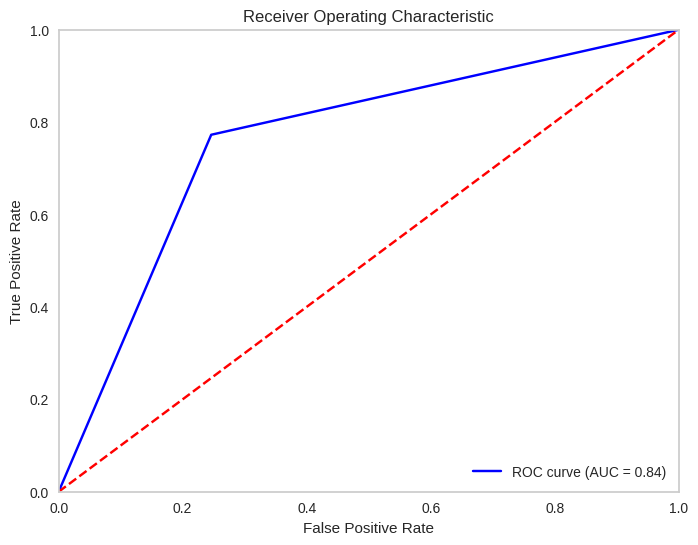

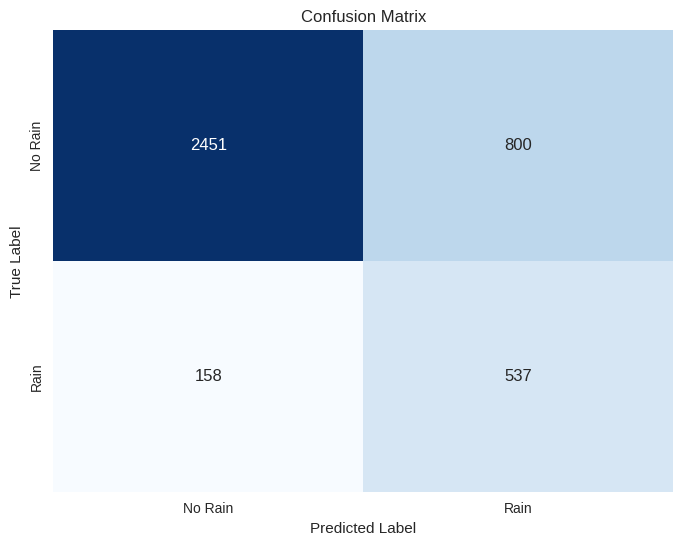

              precision    recall  f1-score   support

           0       0.94      0.75      0.84      3251
           1       0.40      0.77      0.53       695

    accuracy                           0.76      3946
   macro avg       0.67      0.76      0.68      3946
weighted avg       0.84      0.76      0.78      3946



In [ ]:
f1 = f1_score(y_train, y_train_pred)
precision = precision_score(y_train, y_train_pred)
recall = recall_score(y_train, y_train_pred)
accuracy = accuracy_score(y_train, y_train_pred)
auc = roc_auc_score(y_train, y_train_pred_prob)
cm = confusion_matrix(y_train, y_train_pred)
fpr, tpr, thresholds = roc_curve(y_train, y_train_pred)
print("Training Score")
print("F1 score: ", f1)
print("Precision score: ", precision)
print("Recall score: ", recall)
print("Accuracy: ", accuracy)
print("AUC: ", auc)
print("-------------------------------")
f1 = f1_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
accuracy = accuracy_score(y_test, y_test_pred)
auc = roc_auc_score(y_test, y_test_pred_prob)
cm = confusion_matrix(y_test, y_test_pred)
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred)
print("Testing Score")
print("F1 score: ", f1)
print("Precision score: ", precision)
print("Recall score: ", recall)
print("Accuracy: ", accuracy)
print("AUC: ", auc)
# Plot confusion matrix for better visualization
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['No Rain', 'Rain'], yticklabels=['No Rain', 'Rain'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Optionally print a classification report
print(classification_report(y_test, y_test_pred))

In [ ]:
"""
PREVIOUS RESULTS

# Create a Keras model
nn_model = Sequential()
# Add hidden layers with 'relu' or 'tanh'
nn_model.add(Dense(128, input_dim=X.shape[1], activation='relu', kernel_regularizer=l2(0.01)))  # Hidden Layer 1
nn_model.add(Dropout(0.3))  # Dropout layer after the first hidden layer
nn_model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))  # Hidden Layer 2
nn_model.add(Dropout(0.3))  # Dropout layer after the second hidden layer
nn_model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.01)))  # Hidden Layer 3
nn_model.add(Dropout(0.3))  # Dropout layer after the third hidden layer
# Add output layer with 'sigmoid'
nn_model.add(Dense(1, activation='sigmoid'))  # Output Layer

Training Score
F1 score:  0.5461758650128057
Precision score:  0.44323090716439806
Recall score:  0.7114076399790685
Accuracy:  0.7820886884811072
AUC:  0.8411882771259686
-------------------------------
Testing Score
F1 score:  0.5419520547945206
Precision score:  0.4389736477115118
Recall score:  0.7080536912751678
Accuracy:  0.7677951388888888
AUC:  0.8285187313496667

In [ ]:
y_kaggle_preds = nn_model.predict(X_kaggle_df[engineering_features])
y_kaggle_preds = np.array(y_kaggle_preds)
y_kaggle_preds = y_kaggle_preds.flatten()
y_kaggle_preds = (y_kaggle_preds > 0.5).astype(int)

312/312 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


#EXPORTING

In [ ]:
#csv_export
row_ids = [f"Row{i}" for i in range(len(y_kaggle_preds))]  # Create Row IDs
prediction_df = pd.DataFrame({
    'row ID': row_ids,
    'Predict-RainTomorrow': y_kaggle_preds
})

prediction_df.to_csv('predictions.csv', index=False)

In [ ]:
prediction_df.shape

(9965, 2)